# Import Libraries

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

# Obtain Data

Read csv with churn data into pandas

In [2]:
df = pd.read_csv('Data/Churn_Modeling.csv')
print('df shape: ', df.shape)
df.head()

df shape:  (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Scrub Data

Use df.info() to determine what data scrubbing needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Drop columns not useful for modeling

In [4]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Create dummy variables for categorical variables

In [5]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Confirm data is scrubbed with df.info()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


# Explore Data

Calculate shape of customer churn dataset

In [7]:
df.shape

(10000, 12)

Use Isolation Forest to identify the .1% greatest outlier datapoints and confirm no outlier removal needed

In [8]:
if_x = df.drop(columns='Exited')
if_ss = StandardScaler()
ss_if_x = pd.DataFrame(if_ss.fit_transform(if_x), columns=if_x.columns)

is_for = IsolationForest(contamination=.001, random_state=71)
is_for.fit(ss_if_x)
ss_if_x['Outlier'] = is_for.predict(ss_if_x)
ss_if_x[ss_if_x['Outlier']==-1]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Outlier
1469,1.743134,0.960993,-1.387538,0.707933,4.246377,-1.547768,-1.030670,1.148962,1.727904,-0.573809,-1.095988,-1
1876,-0.108939,0.007457,1.378686,0.883437,4.246377,-1.547768,0.970243,-1.619069,1.727904,-0.573809,0.912419,-1
2154,-0.460730,2.486650,1.724464,0.798483,2.527057,-1.547768,-1.030670,-1.603762,1.727904,-0.573809,0.912419,-1
2872,-2.188641,1.247053,-0.695982,0.315900,4.246377,0.646092,-1.030670,1.717760,-0.578736,1.742740,0.912419,-1
4013,0.718803,1.723821,-1.387538,1.371863,4.246377,-1.547768,-1.030670,-1.268432,1.727904,-0.573809,-1.095988,-1
4166,2.063884,0.579578,-0.004426,1.564284,4.246377,0.646092,-1.030670,-1.641886,-0.578736,1.742740,-1.095988,-1
5337,1.701747,1.723821,-0.004426,-1.225848,2.527057,-1.547768,-1.030670,-1.063317,-0.578736,1.742740,-1.095988,-1
6279,1.101634,1.533114,1.378686,0.654038,4.246377,0.646092,-1.030670,-0.102643,-0.578736,1.742740,-1.095988,-1
6721,1.794868,3.630893,-0.695982,-0.784827,0.807737,-1.547768,0.970243,-1.692712,1.727904,-0.573809,0.912419,-1
9747,-0.419342,2.868064,-0.004426,0.153096,2.527057,-1.547768,-1.030670,1.611140,1.727904,-0.573809,-1.095988,-1


Calculate descriptive statistics for each variable in dataset

In [9]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


Calculate and plot class distribution of dependent variable

Churned customer proportion: 0.2037


Text(0, 0.5, 'Count')

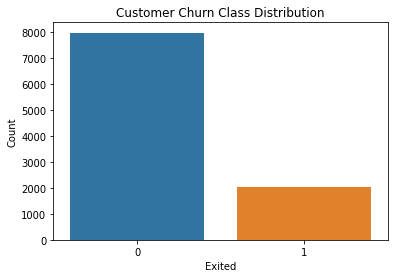

In [10]:
print('Churned customer proportion:', df['Exited'].mean())
fig, ax = plt.subplots()
sns.countplot(x='Exited', data=df, ax=ax)
ax.set_title('Customer Churn Class Distribution')
ax.set_ylabel('Count')

Plot histogram for each variable

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


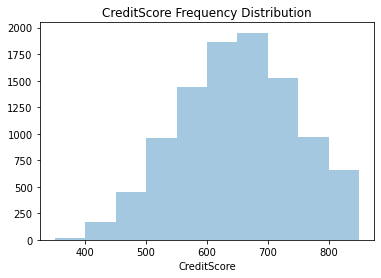

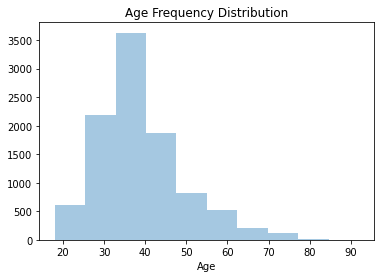

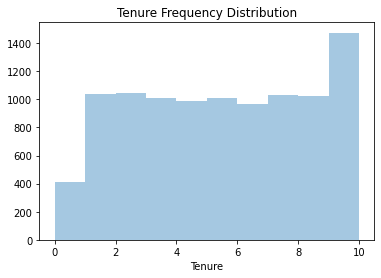

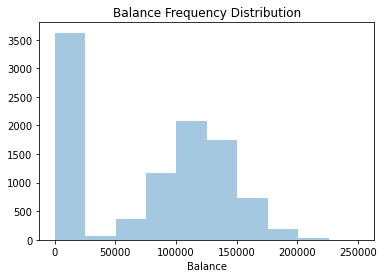

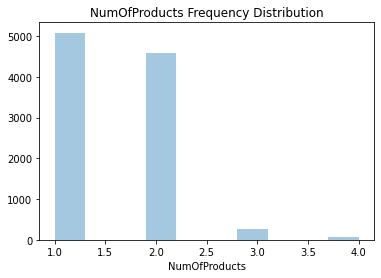

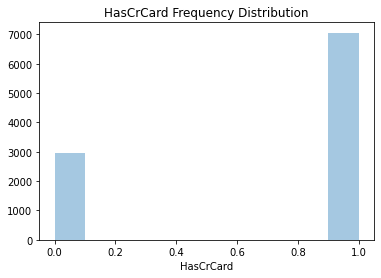

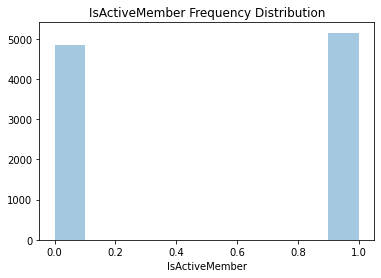

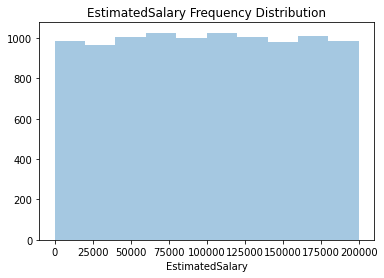

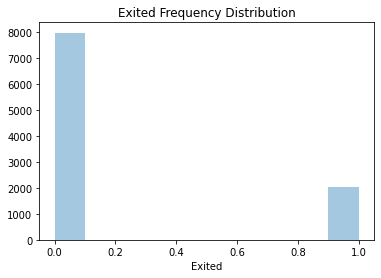

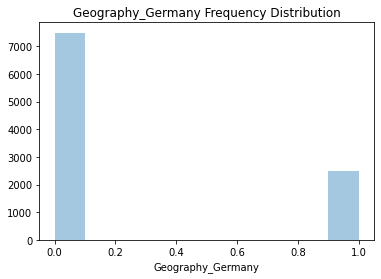

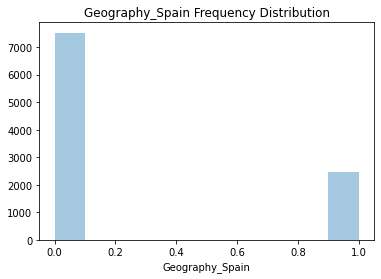

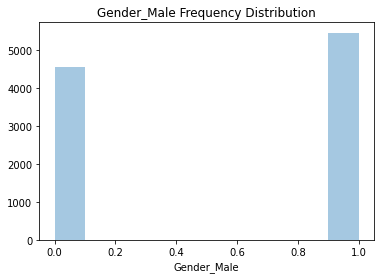

In [11]:
for col in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[col], kde=False, bins=10, ax=ax)
    ax.set_title(f'{col} Frequency Distribution')

# Explore Data

Create x and y variables

In [12]:
x = df.drop(columns='Exited')
y = df['Exited']

Perform train test split on x and y variables

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=73)

Standard scale x and y variables

In [14]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns=x.columns)

Build and evaluate dummy classifiermodel

In [15]:
dc = DummyClassifier(strategy='stratified')
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)

print('Dummy Classifier Evaluation')
print('Train f1 score', f1_score(y_train, y_train_pred_dc))
print('Train precision score', precision_score(y_train, y_train_pred_dc))
print('Test f1 score', f1_score(y_test, y_test_pred_dc))
print('Test precision score', precision_score(y_test, y_test_pred_dc))

Dummy Classifier Evaluation
Train f1 score 0.1992161985630307
Train precision score 0.1998689384010485
Test f1 score 0.21297192642787996
Test precision score 0.20676691729323307


Build and evaluate logistic regression model

In [16]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

print('Logistic Regression Evaluation')
print('Train f1 score', f1_score(y_train, y_train_pred_lr))
print('Train precision score', precision_score(y_train, y_train_pred_lr))
print('Test f1 score', f1_score(y_test, y_test_pred_lr))
print('Test precision score', precision_score(y_test, y_test_pred_lr))

Logistic Regression Evaluation
Train f1 score 0.30953521801629136
Train precision score 0.5862068965517241
Test f1 score 0.3343023255813954
Test precision score 0.6149732620320856


Gridsearch knn model

In [17]:
gs_knn_dict = {'n_neighbors': range(1,21)}
gs_knn_model = KNeighborsClassifier()
gs_knn = GridSearchCV(estimator=gs_knn_model, param_grid=gs_knn_dict, scoring='f1', n_jobs=-1, cv=10, verbose=1)
gs_knn.fit(x_train, y_train)
print('knn Gridsearch')
print('Best score:', gs_knn.best_score_)
print('Best params:', gs_knn.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
knn Gridsearch
Best score: 0.47879071292866093
Best params: {'n_neighbors': 3}


Evaluate top performing gridsearch knn model

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_train_pred_knn = knn.predict(x_train)
y_test_pred_knn = knn.predict(x_test)

print('KNN Evaluation')
print('Train f1 score', f1_score(y_train, y_train_pred_knn))
print('Train precision score', precision_score(y_train, y_train_pred_knn))
print('Test f1 score', f1_score(y_test, y_test_pred_knn))
print('Test precision score', precision_score(y_test, y_test_pred_knn))

KNN Evaluation
Train f1 score 0.7165178571428571
Train precision score 0.8359375
Test f1 score 0.48484848484848486
Test precision score 0.5826330532212886


Gridsearch adaboost model

In [19]:
gs_ab_dict = {'learning_rate': [x/10 for x in range(1,21)], 'n_estimators': [50, 100, 250]}
gs_ab_model = AdaBoostClassifier()
gs_ab = GridSearchCV(estimator=gs_ab_model, param_grid=gs_ab_dict, scoring='f1', n_jobs=-1, cv=10, verbose=1)
gs_ab.fit(x_train, y_train)
print('Adaboost Gridsearch')
print('Best score:', gs_ab.best_score_)
print('Best params:', gs_ab.best_params_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Adaboost Gridsearch
Best score: 0.5753290481934646
Best params: {'learning_rate': 1.3, 'n_estimators': 100}


Evaluate top performing adaboost model

In [20]:
ab = AdaBoostClassifier(learning_rate=1.3, n_estimators=100)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)

print('Adaboost Evaluation')
print('Train f1 score', f1_score(y_train, y_train_pred_ab))
print('Train precision score', precision_score(y_train, y_train_pred_ab))
print('Test f1 score', f1_score(y_test, y_test_pred_ab))
print('Test precision score', precision_score(y_test, y_test_pred_ab))

Adaboost Evaluation
Train f1 score 0.586802827965436
Train precision score 0.7396039603960396
Test f1 score 0.580722891566265
Test precision score 0.7325227963525835


# Interpret Results

Create dummy classifier confusion matrix

[Text(0, 0.5, 'Remained'), Text(0, 1.5, 'Exited')]

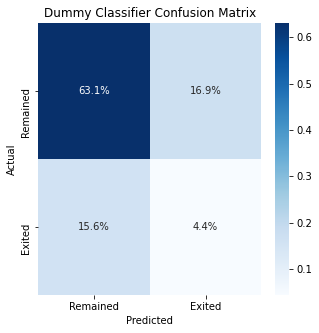

In [30]:
dc_cm = confusion_matrix(y_test, y_test_pred_dc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(dc_cm/np.sum(dc_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Dummy Classifier Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Remained','Exited'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Remained','Exited'])

Create logistic regression confusion matrix

[Text(0, 0.5, 'Remained'), Text(0, 1.5, 'Exited')]

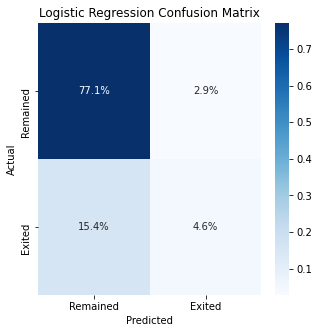

In [31]:
lr_cm = confusion_matrix(y_test, y_test_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Logistic Regression Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Remained','Exited'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Remained','Exited'])

Create knn confusion matrix

[Text(0, 0.5, 'Remained'), Text(0, 1.5, 'Exited')]

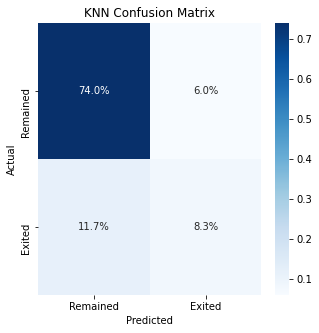

In [32]:
knn_cm = confusion_matrix(y_test, y_test_pred_knn)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(knn_cm/np.sum(knn_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('KNN Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Remained','Exited'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Remained','Exited'])

Create adaboost confusion matrix

[Text(0, 0.5, 'Remained'), Text(0, 1.5, 'Exited')]

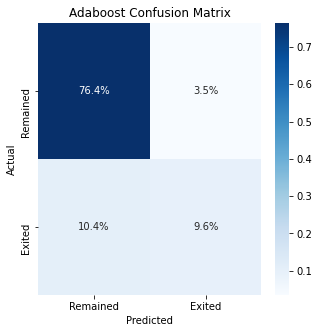

In [33]:
ab_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(ab_cm/np.sum(ab_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Adaboost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Remained','Exited'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Remained','Exited'])

Create df of Adaboost feature importances

In [42]:
feature_importances_df = pd.DataFrame(ab.feature_importances_, columns = ['Importance'])
feature_importances_df['Feature'] = x.columns
feature_importances_df.sort_values(by='Importance', inplace=True)
feature_importances_df

,Importance,Feature
5,0.00,HasCrCard
9,0.00,Geography_Spain
6,0.02,IsActiveMember
10,0.02,Gender_Male
2,0.03,Tenure
8,0.03,Geography_Germany
4,0.05,NumOfProducts
0,0.17,CreditScore
3,0.18,Balance
1,0.24,Age


Plot adaboost feature importances

[Text(0, 0, 'HasCrCard'),
 Text(1, 0, 'Geography_Spain'),
 Text(2, 0, 'IsActiveMember'),
 Text(3, 0, 'Gender_Male'),
 Text(4, 0, 'Tenure'),
 Text(5, 0, 'Geography_Germany'),
 Text(6, 0, 'NumOfProducts'),
 Text(7, 0, 'CreditScore'),
 Text(8, 0, 'Balance'),
 Text(9, 0, 'Age'),
 Text(10, 0, 'EstimatedSalary')]

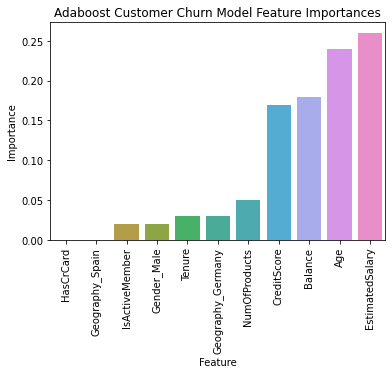

In [47]:
fig, ax  = plt.subplots()
sns.barplot(x='Feature', y='Importance', data=feature_importances_df, ax=ax)
ax.set_title('Adaboost Customer Churn Model Feature Importances')
ax.set_xticklabels(feature_importances_df['Feature'], rotation=90)